In [78]:
import lib.tf_silent
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B
import pandas as pd
import time

In [79]:
import lib.tf_silent
start_time = time.time()

if __name__ == "__main__":
    """
    Test the physics informed neural network (PINN) model for Burgers' equation
    """

    # number of training samples
    num_train_samples = 1250
    # num_collocation_samples = 8000
    # number of test samples
    num_test_samples = 3201
    # kinematic viscosity
    nu = 0.01 / np.pi

    # build a core network model
    network = Network.build()
    network.summary()
    # build a PINN model
    pinn = PINN(network, nu).build()

    # create training input
    tx_eqn = np.random.rand(num_train_samples, 2)  # t_eqn =  0 ~ +1
    tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1  # x_eqn = -1 ~ +1
    tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
    tx_ini[..., 0] = 0  # t_ini =  0
    tx_bnd = np.random.rand(num_train_samples, 2)  # t_bnd =  0 ~ +1
    tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1  # x_bnd = -1 or +1
    # create training output
    u_eqn = np.zeros((num_train_samples, 1))  # u_eqn = 0
    u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])  # u_ini = -sin(pi*x_ini)
    u_bnd = np.zeros((num_train_samples, 1))  # u_bnd = 0

    # train the model using L-BFGS-B algorithm
    x_train = [tx_eqn, tx_ini, tx_bnd]
    y_train = [u_eqn, u_ini, u_bnd]
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()

    # predict u(t,x) distribution
    # # In theory, if change third argument of t_flat and x_flat linspace from num_test_samples
    # # can choose grid resolution.
    t_flat = np.linspace(0, 1, num_test_samples)
    x_flat = np.linspace(-1, 1, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # ================================================
    comp_time = time.time() - start_time
    print(comp_time, ' seconds')
    # ------------------------------------------------------

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_45 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

In [80]:
# Add a line here to save the data for comparison. #    CELL 3
#np.savetxt("t_NN.csv", t, delimiter=",")
#np.savetxt("x_NN.csv", x, delimiter=",")
##np.savetxt("../results/Uall_1,25k_NNdef_e12_001pi.csv", u, delimiter=",")
print("Array exported to files")

Array exported to files


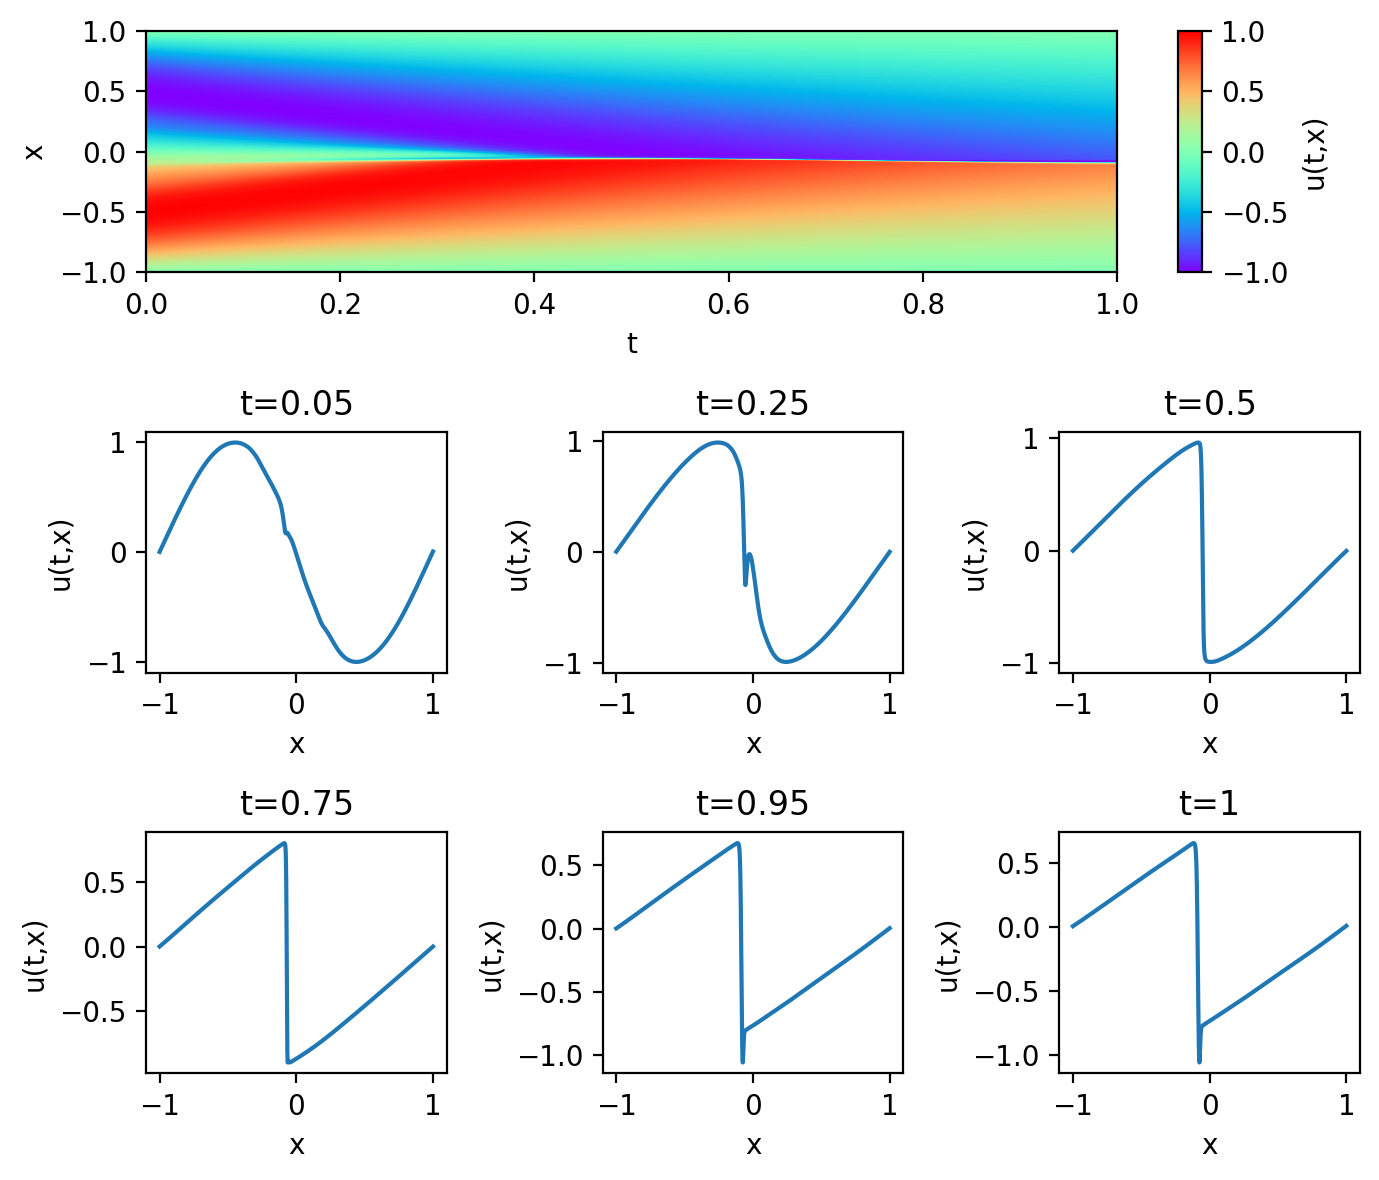

In [81]:
# plot u(t,x) distribution as a color-map       # CELL 4
fig = plt.figure(figsize=(7, 6), dpi = 200)
gs = GridSpec(3, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap="rainbow")
plt.xlabel("t")
plt.ylabel("x")
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label("u(t,x)")
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.05, 0.25, 0.5] #, 0.75, 0.95]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title("t={}".format(t_cs))
    plt.xlabel("x")
    plt.ylabel("u(t,x)")

    #plot second batch of cross sections
t_cross_sections = [0.75, 0.95, 1]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[2, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title("t={}".format(t_cs))
    plt.xlabel("x")
    plt.ylabel("u(t,x)")

plt.tight_layout()


#CHANGE FOR EVERY CASE
###plt.savefig("../figures/Fig_1,25k_NNdef_e12_001pi.png", dpi = 300)

plt.show()



In [82]:
#U vector               # CELL 5
print(u.shape)
###np.savetxt("../results/Uend_1,25k_NNdef_e12_001pi.csv", u, delimiter=",")    #Save vector for plotting all together in one axis


(3201, 1)


In [83]:
u_fdm_all = pd.read_csv('../u_fd.csv', header=None) #Import all u
u_fdm_end = u_fdm_all.iloc[:,-1]                    #Extract last vector
u_fdm_end = pd.DataFrame.to_numpy(u_fdm_end)        #Changes from dataframe to numpy array


In [84]:

#Maths
u_error = (np.abs(u[:,0] - u_fdm_end))
u_mean = np.mean(u_error)
u_std = np.std(u_error)
print('The mean error in u was ', u_mean,' with s.d. of ',u_std,'.\n')
print("--- %s seconds ---" % (comp_time))

# fig = plt.figure(figsize=(7, 4), dpi = 200)
# plt.plot(x_flat, u, x_flat, u_fdm_end)
# plt.title("U at t=1")
# plt.xlabel("x")
# plt.ylabel("u(t,x)")

# plt.show()

The mean error in u was  0.06839983272860725  with s.d. of  0.2976454519849659 .

--- 65.12849044799805 seconds ---
